# Development of a step counter

The strategy is to train a walk detection model to filter walk segments in the
accelerometer trace, over which a peak finding algorithm is then applied to
estimate the step count.

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('src/')

import os
import re
import warnings
import datetime
import pathlib
import glob
import numpy as np
import pandas as pd
import joblib
from scipy import signal
from sklearn import metrics
from imblearn.ensemble import BalancedRandomForestClassifier
from hmmlearn import hmm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from stepcount import models
from stepcount import features
from stepcount import hmm_utils


## Setup

In [2]:
SAMPLE_RATE = 100  # Hz
WINDOW_SEC = 5  # seconds
STEPTOL = 3  # at least this many steps in a window to count as walking
WINDOW_LEN = int(WINDOW_SEC * SAMPLE_RATE)  # ticks
N_ESTIMATORS = 1000
CV = -1
N_JOBS = 4
OUTDIR = pathlib.Path(f"outputs-dev/{datetime.datetime.now().strftime('%Y-%m-%d')}")

os.makedirs(OUTDIR, exist_ok=True)
print(f"OUTDIR: {OUTDIR}")

DEBUG = True
if DEBUG:
    print('\n##################\n DEBUG mode is ON\n##################')
    N_DEBUG_FILES = 10
    N_ESTIMATORS = 200
    CV = 2
    N_JOBS = 1


OUTDIR: outputs-dev/2023-07-14

##################
 DEBUG mode is ON
##################


In [3]:
# --------------------------
#   Some utility functions
# --------------------------

def read_csv(filename):
    """ Data loader """

    data = pd.read_csv(
        filename, 
        parse_dates=['timestamp'], 
        index_col='timestamp',
        dtype={
            'x': 'f4', 
            'y': 'f4', 
            'z': 'f4', 
            'annotation': 'i2',
        }
    )
    return data


def plotw(w, ax, lp=None, find_peaks=False, find_peaks_params=None):
    """ Plot a window accel trace """

    v = np.linalg.norm(w[['x', 'y', 'z']].to_numpy(), axis=1)  # absolute accel magnitude
    v = v - 1  # detrend: "remove gravity"

    if lp:
        # lowpass filter
        v = features.butterfilt(v, lp, SAMPLE_RATE)

    xanno = np.argwhere(w['annotation'].to_numpy()).ravel()
    yanno = v[xanno]
    ax.plot(v)
    ax.scatter(xanno, yanno, marker='x', c='k', label='step')
    title = f"steps: {len(xanno)}"

    if find_peaks:
        find_peaks_params = find_peaks_params or {}
        peaks, _ = signal.find_peaks(v, **find_peaks_params)
        ax.scatter(peaks, v[peaks], marker='o', fc='none', ec='r', label='find_peaks')
        title = f"{title} | find_peaks: {len(peaks)}"

    ax.grid(True)
    ax.legend()
    ax.set_title(title)
    return ax


def plotsome(data, **kwargs):
    """ Plot some windows """

    NFIGS_WALK = 10  # walk windows to plot
    NFIGS_NOTWALK = 5  # non-walk windows to plot
    NFIGS = NFIGS_WALK + NFIGS_NOTWALK
    NROWS = 3
    NCOLS = NFIGS // NROWS
    FIGSIZE = (4 * NCOLS, 3 * NROWS)

    fig, axs = plt.subplots(ncols=NCOLS, nrows=NROWS, figsize=FIGSIZE)

    n = 0
    for _, w in data.resample(f"{WINDOW_SEC}s"):
        if w['annotation'].sum() >= STEPTOL:
            plotw(w, axs.flat[n], **kwargs)
            n += 1
        if n >= NFIGS_WALK: break

    m = 0
    for _, w in data.resample(f"{WINDOW_SEC}s"):
        if w['annotation'].sum() < STEPTOL:
            plotw(w, axs.flat[n + m], **kwargs)
            m += 1
        if m >= NFIGS_NOTWALK: break

    return fig


## Visuals

Always good idea to visualize the data.

/tmp/ipykernel_5223/3004019485.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


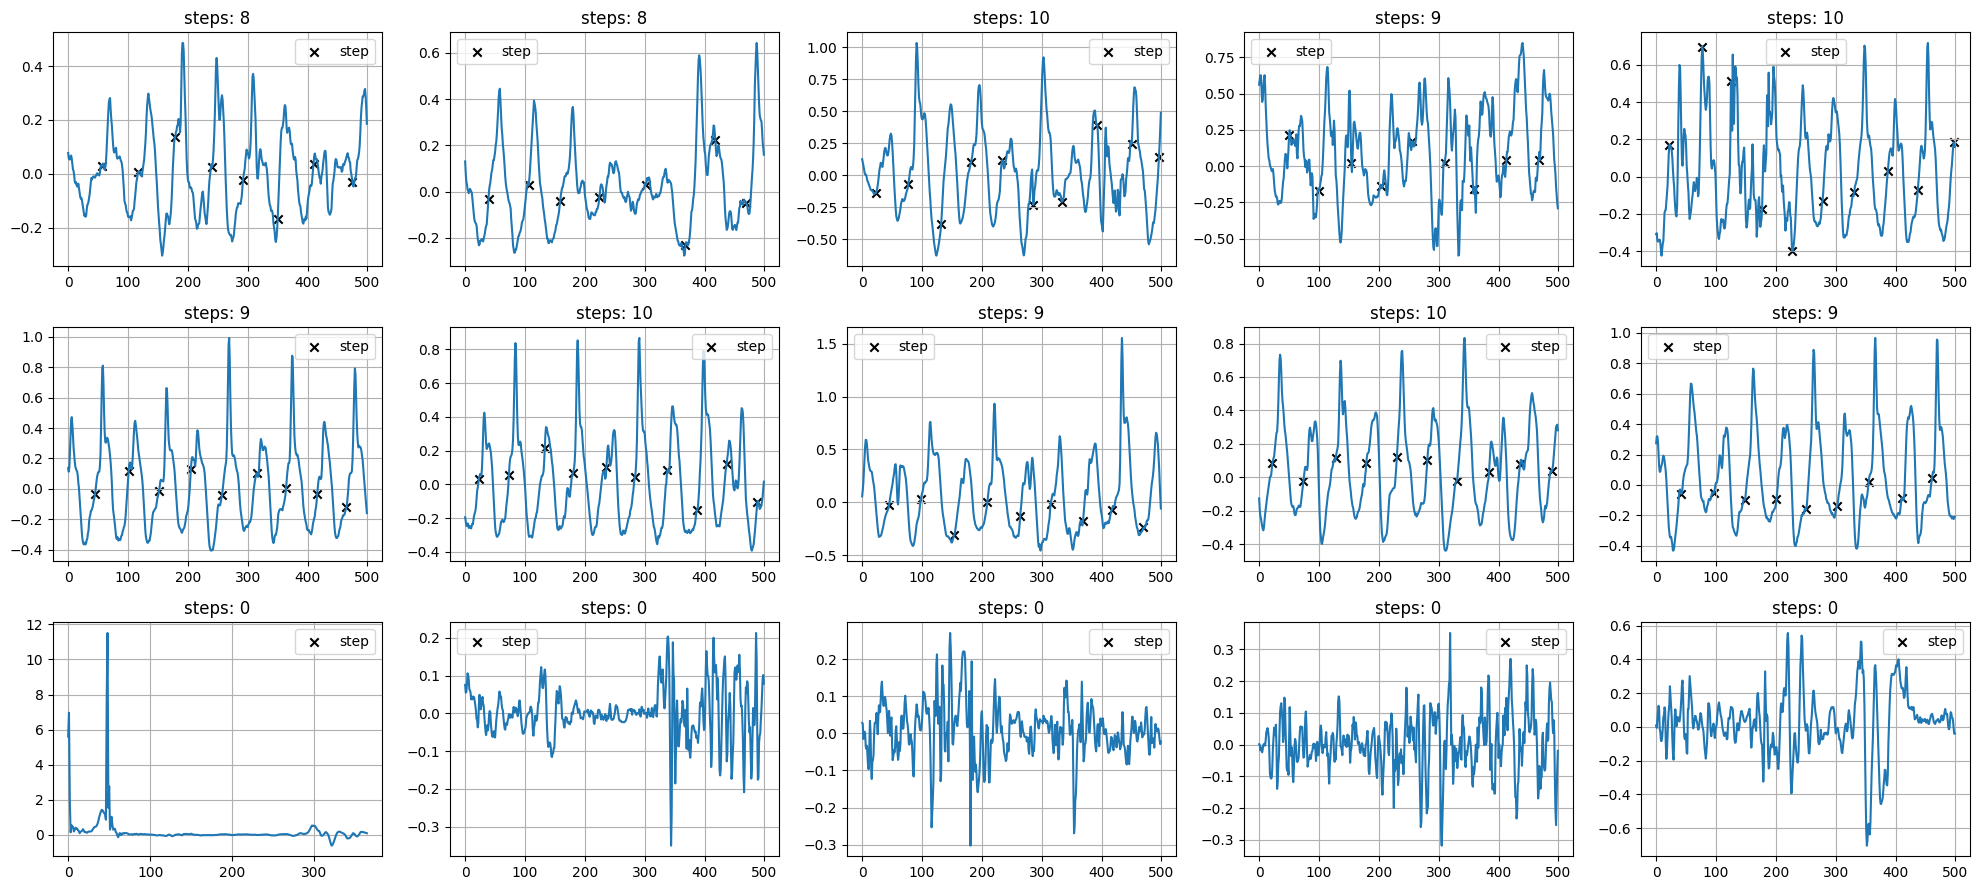

In [4]:
data = read_csv("data/OxWalk_Dec2022/Wrist_100Hz/P01_wrist100.csv")

fig = plotsome(data)
fig.tight_layout()
fig.show()

## Step counts

To infer steps from accelerometry, we assume that steps correspond to peaks in acceleration.
This is reasonable: You might recall that conundrum in highschool physics about
instantaneaous collisions resulting in infinite forces.

We will use the peak finding algorithm implemented in `scipy.find_peaks`. 

Let's visualize the traces again, this time enabling peak finding.

/tmp/ipykernel_5223/1322667742.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


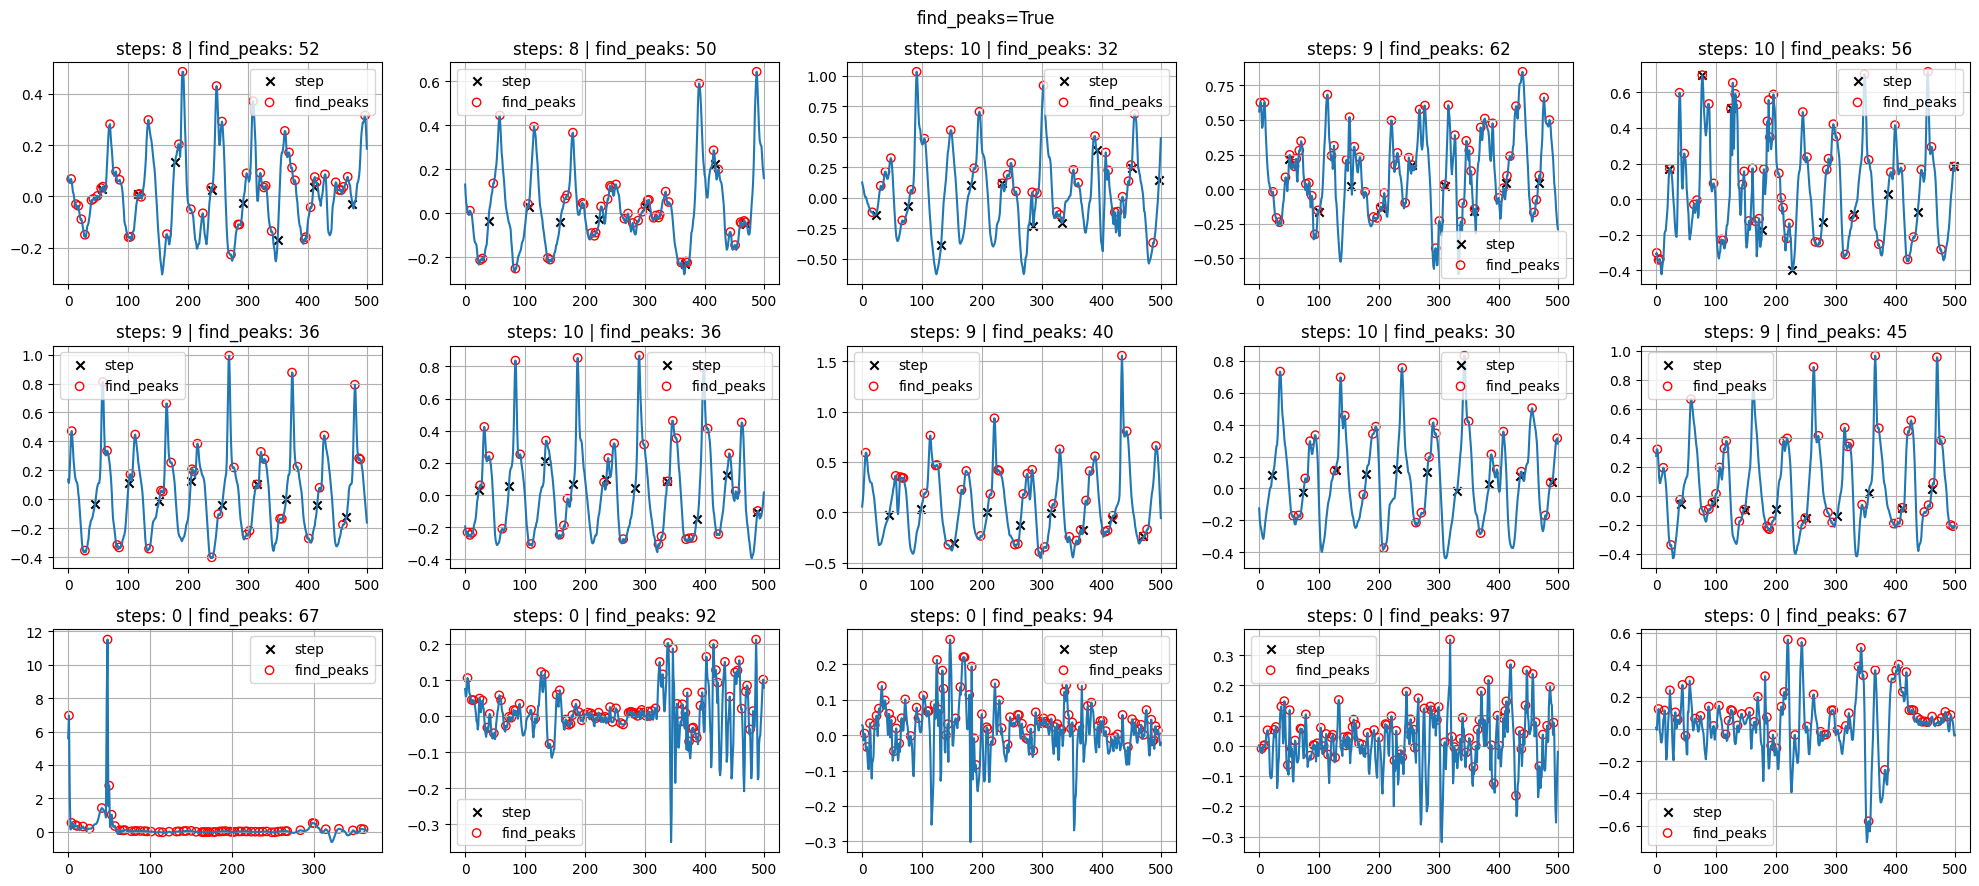

In [5]:
fig = plotsome(data, find_peaks=True)
fig.suptitle("find_peaks=True")
fig.tight_layout()
fig.show()

Peak finding with default parameters finds every single peak present in the signal, which is not really what we want.

We can tune the peak finder to only consider peaks that satisfy certain
conditions. Two parameters that we can tune are the minimum `distance` between
peaks and the minimum `prominence` of the peaks. The higher these values, the
stricter the peak selection becomes.

After eyeballing the plots, let's try values 0.1 for `prominence` and 0.2 sec for `distance`.


/tmp/ipykernel_5223/2800082426.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


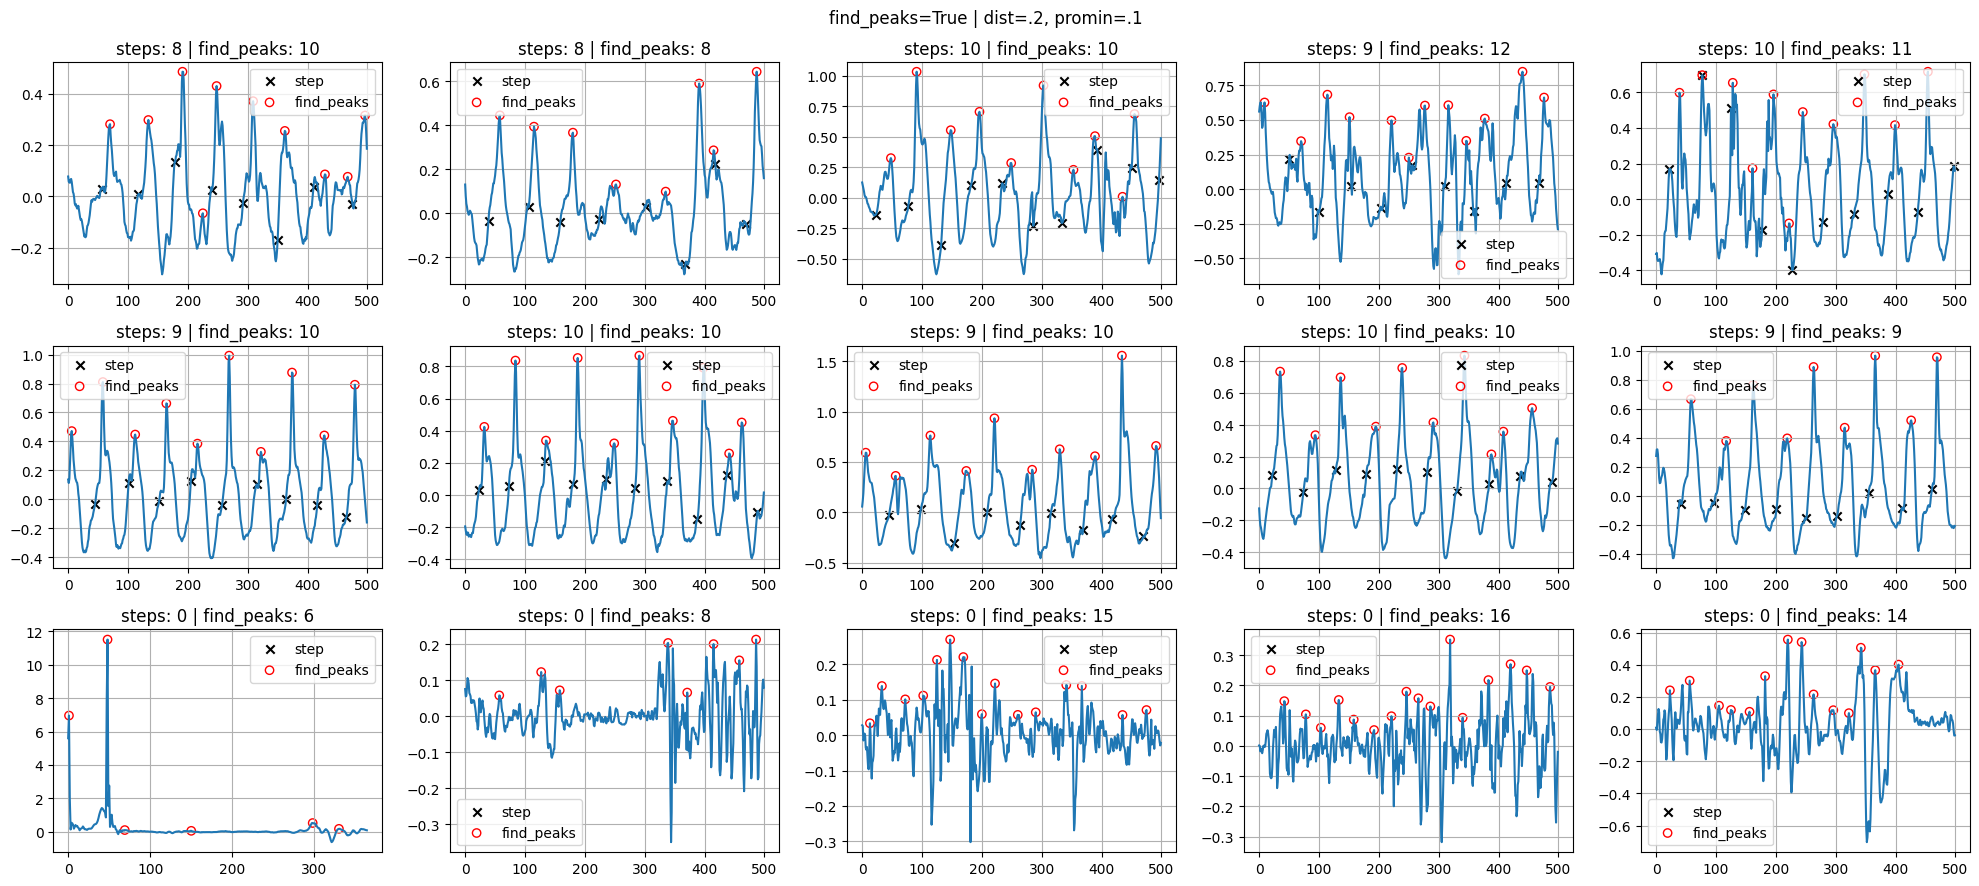

In [6]:
fig = plotsome(
    data, 
    find_peaks=True,
    find_peaks_params={
        'distance': .2 * SAMPLE_RATE,  # 0.2s in ticks
        'prominence': .1
    }
)
fig.suptitle("find_peaks=True | dist=.2, promin=.1")
fig.tight_layout()
fig.show()

We get big improvements after tuning the peak finder.

A common signal processing technique is to filter out frequencies that are irrelevant for the task.
In activity recognition, a lowpass filter with 3Hz cutoff is commonly applied for walk analysis.

Let's apply a 5Hz lowpass filter. We use a looser cutoff as we might also want to capture running steps, for which 5Hz is a reasonable upper bound. 
For example, Usain Bolt's sprint frequency is around 4.3Hz: https://www.econathletes.com/post/math-for-sprinters-steps-per-second-and-stride-length.

/tmp/ipykernel_5223/4003195315.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


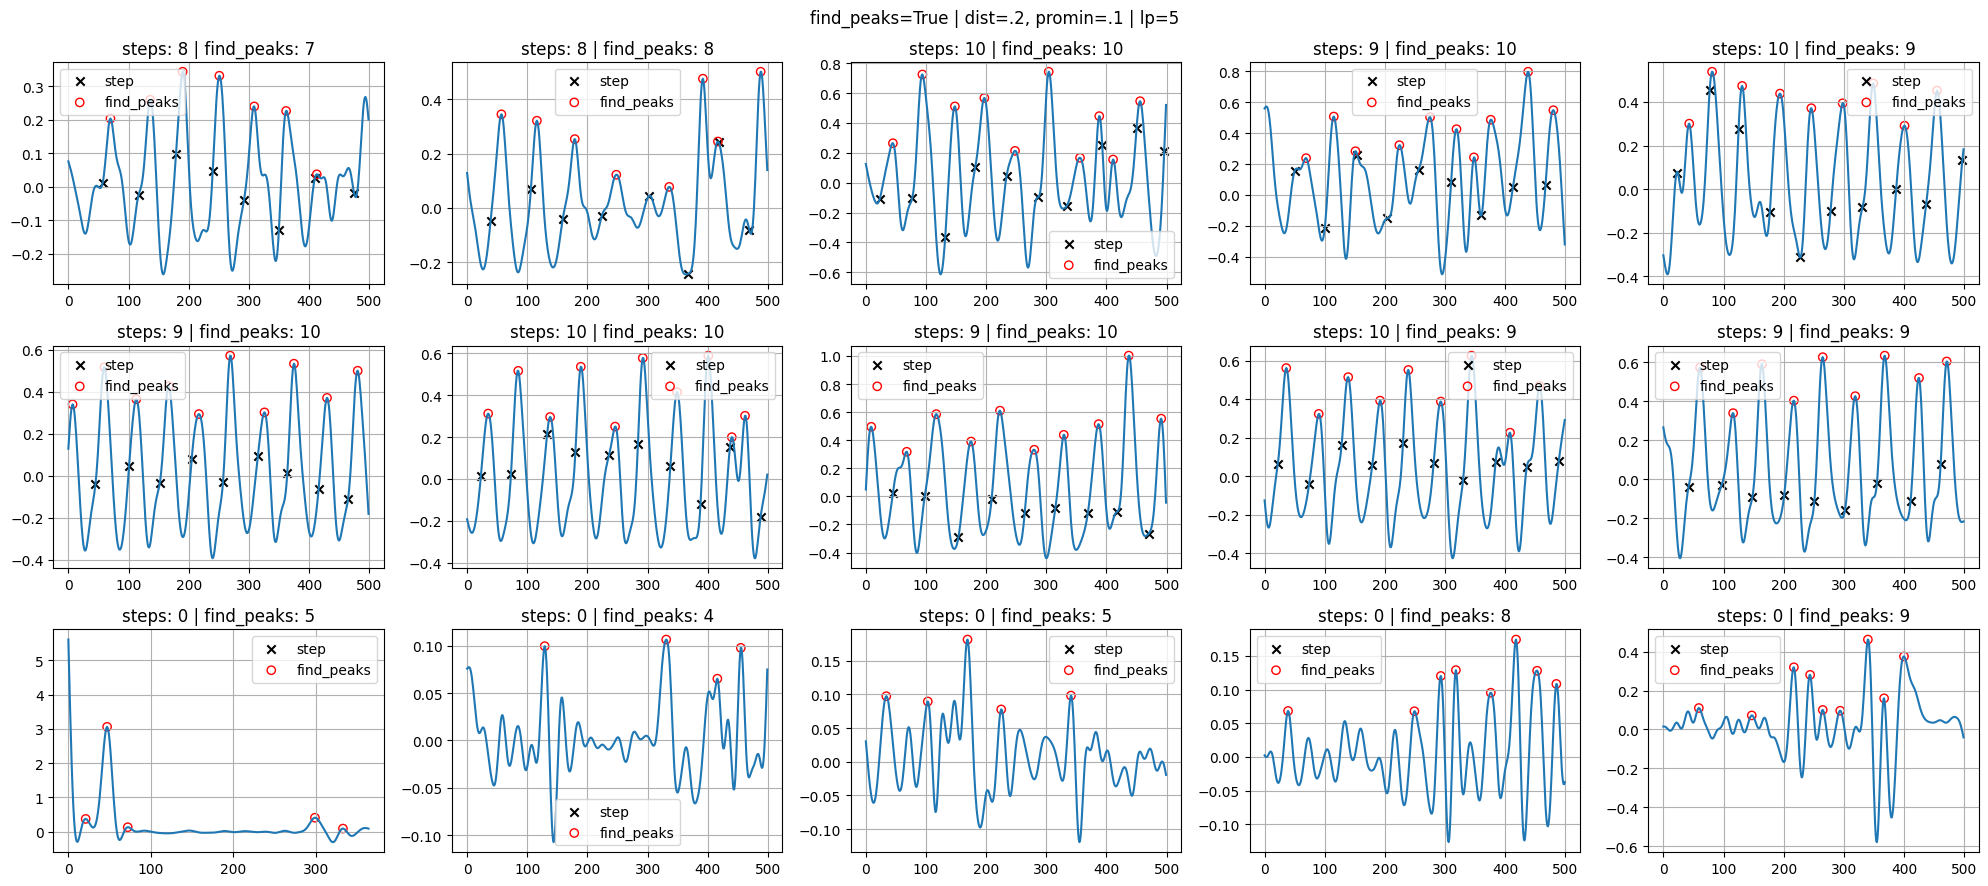

In [7]:
fig = plotsome(
    data, 
    find_peaks=True,
    find_peaks_params={
        'distance': .2 * SAMPLE_RATE,  # 0.2s in ticks
        'prominence': .1
    },
    lp=5,  # 5Hz lowpass filter
)
fig.suptitle("find_peaks=True | dist=.2, promin=.1 | lp=5")
fig.tight_layout()
fig.show()

The filter clears out the signal making it easier to find relevant peaks. It helps most in reducing false positives, especially when high frequencies are present.

While peak finding performs well for walk windows (first two rows), it tends to give false positives in non-walk windows (last row). This motivates us to build a _walk detection model_ to further filter only the walk segments.

## Walk detection model

After splitting the data into 5 sec windows, we extract features commonly used in the activity recognition literature. We then train a random forest to classify each window as either walk or non-walk. Finally, a hidden Markov model is applied to "glue" together the model outputs in a smooth manner.

### Feature extraction

In [8]:
def make_windows(data, window_sec=WINDOW_SEC, sample_rate=SAMPLE_RATE):
    """ Split data into windows, extract features and assign labels """

    X_raw = []
    frame = []

    window_len = int(window_sec * sample_rate)

    for t, w in data.resample(f"{window_sec}s"):

        if len(w) < window_len:
            continue

        steps = w['annotation'].sum()
        is_walk = int(steps >= STEPTOL)
        steps *= is_walk  # only count if it's a walk window
        xyz = w[['x', 'y', 'z']].to_numpy()

        X_raw.append(xyz)

        frame.append({
            'time': t,
            **features.extract_features(xyz, sample_rate),
            'steps': steps,
            'is_walk': is_walk,
        })

    X_raw = np.stack(X_raw)
    frame = pd.DataFrame(frame)

    return X_raw, frame


# ----------------------------------
# Now extract windows for each file
# ----------------------------------

X_raw = []
frame = []

filenames = glob.glob("data/OxWalk_Dec2022/Wrist_100Hz/*.csv")
if DEBUG:
    filenames = filenames[:N_DEBUG_FILES]

for filename in tqdm(filenames):
    data = read_csv(filename)
    _X_raw, _X_frame = make_windows(data)
    pid = re.search(r'(P\d{2})', os.path.basename(filename)).group(1).upper()  # P01, P02, ...
    _X_frame['pid'] = pid

    X_raw.append(_X_raw)
    frame.append(_X_frame)

X_raw = np.concatenate(X_raw)
frame = pd.concat(frame)

print("X_raw shape:", X_raw.shape)
print("frame shape:", frame.shape)
display(frame)

# Save results
outdir = OUTDIR / datetime.datetime.now().strftime('%H-%M-%S')
os.makedirs(outdir, exist_ok=True)
np.save(outdir / "X_raw.npy", X_raw)
frame.to_pickle(outdir / "frame.pkl")

print(f"Saved to {outdir}")

  0%|          | 0/10 [00:00<?, ?it/s]

X_raw shape: (7190, 500, 3)
frame shape: (7190, 36)


,time,avg,std,skew,kurt,min,q25,med,q75,max,...,fft3,fft4,fft5,npeaks,peaks_avg_promin,peaks_min_promin,peaks_max_promin,steps,is_walk,pid
0,2019-07-22 10:59:25,0.006611,0.043389,2.257442,11.211447,-0.098065,-0.007524,0.003026,0.015589,0.276183,...,0.000024,0.000008,0.000033,0.0,0.000000,0.000000,0.000000,0,0,P14
1,2019-07-22 10:59:30,0.004159,0.054975,-0.617589,27.210949,-0.354730,-0.000841,0.003973,0.009286,0.346493,...,0.000004,0.000011,0.000007,0.0,0.000000,0.000000,0.000000,0,0,P14
2,2019-07-22 10:59:35,0.006412,0.030799,-1.665207,6.978625,-0.146083,-0.001942,0.008387,0.019153,0.083698,...,0.000053,0.000022,0.000012,0.0,0.000000,0.000000,0.000000,0,0,P14
3,2019-07-22 10:59:40,0.004602,0.060536,-0.240676,9.814598,-0.319555,-0.020868,0.002375,0.029454,0.285365,...,0.000208,0.000064,0.000035,0.2,0.256202,0.256202,0.256202,0,0,P14
4,2019-07-22 10:59:45,0.007646,0.078840,0.802863,3.900160,-0.238850,-0.021264,-0.000939,0.020445,0.318409,...,0.000089,0.001027,0.001263,0.2,0.328364,0.328364,0.328364,0,0,P14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714,2019-07-22 14:25:10,0.004488,0.091715,-0.072488,0.745771,-0.303624,-0.047804,0.009615,0.054449,0.278073,...,0.000760,0.000474,0.000544,0.6,0.290291,0.250633,0.342767,0,0,P04
715,2019-07-22 14:25:15,0.007246,0.096424,0.190902,0.395945,-0.226798,-0.053418,0.006817,0.063949,0.318407,...,0.000558,0.000680,0.000812,0.4,0.289451,0.254011,0.324891,0,0,P04
716,2019-07-22 14:25:20,0.026418,0.143962,0.629555,1.083558,-0.366700,-0.066921,0.012745,0.099727,0.537701,...,0.001537,0.001065,0.000162,0.6,0.514837,0.470208,0.565497,0,0,P04
717,2019-07-22 14:25:25,0.108812,0.314482,0.481045,0.496889,-0.551867,-0.064548,0.074951,0.278194,1.069859,...,0.002296,0.003265,0.003155,1.2,0.840492,0.288264,1.385163,0,0,P04


Saved to outputs-dev/2023-07-14/16-18-59


### Random forest for walk detection

In [9]:
X_raw = np.load(outdir / "X_raw.npy")
frame = pd.read_pickle(outdir / "frame.pkl")

# Train/Test split
np.random.seed(123)  # for reproducibility
test_pids = np.random.choice(
    frame['pid'].unique(), 
    size=int(0.2 * frame['pid'].nunique()), 
    replace=False
)
frame_test = frame[frame['pid'].isin(test_pids)]
frame_train = frame[~frame['pid'].isin(test_pids)]

print("Test PIDs:", test_pids)
print("Train frame shape:", frame_train.shape)
print("Test frame shape:", frame_test.shape)

Test PIDs: ['P08' 'P14']
Train frame shape: (5752, 36)
Test frame shape: (1438, 36)


In [10]:
not_feats_cols = ['time', 'pid', 'is_walk', 'steps']

X_train = frame_train.drop(columns=not_feats_cols).to_numpy()
Y_train = frame_train['is_walk'].to_numpy()
pid_train = frame_train['pid'].to_numpy()

clf = BalancedRandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=4,
    random_state=42,
    verbose=1
)
clf.fit(X_train, Y_train)

X_test = frame_test.drop(columns=not_feats_cols).to_numpy()
Y_test = frame_test['is_walk'].to_numpy()
pid_test = frame_test['pid'].to_numpy()

Y_test_pred = clf.predict(X_test)

print(metrics.classification_report(Y_test, Y_test_pred))


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


              precision    recall  f1-score   support

           0       0.95      0.89      0.91      1068
           1       0.72      0.85      0.78       370

    accuracy                           0.88      1438
   macro avg       0.83      0.87      0.85      1438
weighted avg       0.89      0.88      0.88      1438



[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


### Hidden Markov model

The random forest classifies each window independently and doesn't account for
temporal dependencies, so we further apply a HMM to smooth the outputs.

In [11]:
hmms = hmm_utils.HMMSmoother().fit(clf.oob_decision_function_, Y_train, pid_train)
Y_test_pred_hmm = hmms.predict(Y_test_pred, pid_test)
print(metrics.classification_report(Y_test, Y_test_pred_hmm))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1068
           1       0.82      0.80      0.81       370

    accuracy                           0.90      1438
   macro avg       0.87      0.87      0.87      1438
weighted avg       0.90      0.90      0.90      1438



## End-to-end training

In [12]:
# Cleanup
del X_raw, frame, frame_train, frame_test, X_train, Y_train, pid_train, X_test, Y_test, pid_test

# ---------------------
#  End-to-end training
# ---------------------

X_raw = np.load(outdir / 'X_raw.npy')
frame = pd.read_pickle(outdir / 'frame.pkl')

Y = frame['steps'].to_numpy()  # NOTE: Y is the number of steps in a window
pid = frame['pid'].to_numpy()

wd_params = {'calib_method': 'balanced_accuracy',
             'clf_params': {'n_estimators': N_ESTIMATORS},
             'hmm_params': {'use_hmmlearn': True,
                            'n_components': 2,
                            'ste': '',
                            'n_iter': 0,
                            'n_trials': 0,
                            'startprob': np.array([0.5, 0.5]),
                            'transmat': np.array([[0.95, 0.05],
                                                  [0.1, 0.9]])},
             'verbose': True,
             'pnr': None}

sc = models.StepCounter(
    window_sec=WINDOW_SEC,
    sample_rate=SAMPLE_RATE,
    steptol=STEPTOL,
    pnr=None,
    cv=CV,
    wd_type='rf',
    wd_params=wd_params,
    n_jobs=N_JOBS,
    verbose=True,
)

sc.fit(X_raw, Y, pid)

joblib.dump(sc, outdir / 'model.joblib')

Running cross_val_predict...
Fitting walk detector...
Tuning step counter...


['outputs-dev/2023-07-14/16-18-59/model.joblib']